# Installs and Imports

In [ ]:
!pip install transformers

In [ ]:
import os
import re
import requests
import zipfile
import sys
import time
import logging
import textwrap
import numpy as np
import pandas as pd
from subprocess import call
from sklearn.metrics.pairwise import cosine_similarity

from collections import defaultdict
from multiprocessing import Pool
from tqdm.auto import tqdm, trange
from itertools import chain

from transformers import TFBertForQuestionAnswering, TFBertModel, BertTokenizer
                          
from transformers.optimization import AdamW, get_linear_schedule_with_warmup

import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Setup Logger
if '__file__' not in globals():
  __file__ = "."
logger = logging.getLogger(__file__)

# Logger config
logging.basicConfig(level=logging.INFO)

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

logger.info('__Python VERSION: %s', sys.version)
logger.info("tensorflow version: %s", tf.__version__)
logger.info("keras version: %s", tf.keras.__version__)
logger.info("Eager Execution Enabled: %s", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
logger.info("Number of replicas: %s", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
logger.info("Devices: %s", devices)
logger.info(tf.config.experimental.list_logical_devices('GPU'))

logger.info("GPU Available: %s", tf.config.list_physical_devices('GPU'))
logger.info("All Pysical Devices: %s", tf.config.list_physical_devices())

# nvidia-smi
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

INFO:.:__Python VERSION: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
INFO:.:tensorflow version: 2.6.0
INFO:.:keras version: 2.6.0
INFO:.:Eager Execution Enabled: True


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:.:Number of replicas: 1
INFO:.:Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
INFO:.:[]
INFO:.:GPU Available: []
INFO:.:All Pysical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)


def save_model(model, path="models",model_name="model01"):

  # Ensure path exists
  if not os.path.exists(path):
      os.mkdir(path)

  # Save the enitire model (structure + weights)
  model.save(os.path.join(path,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(path,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(path,model_name+".json"), "w") as json_file:
      json_file.write(model_json)


# Download datasets

In [ ]:
start_time = time.time()

download_file("https://storage.googleapis.com/dogs_text/dogs_qa.csv", base_path="datasets", extract=False)
download_file("https://storage.googleapis.com/dogs_text/dogs_website_memos.csv", base_path="datasets", extract=False)
download_file("https://storage.googleapis.com/dogs_meta/data_dictionary.txt", base_path="datasets", extract=False)
download_file("https://storage.googleapis.com/dogs_meta/dogs.csv", base_path="datasets", extract=False)

execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

datasets_path = "datasets"

# Data Dictionary
data_dictionary_path = os.path.join(datasets_path,"data_dictionary.txt")
with open(data_dictionary_path, 'r') as file:
  data_dictionary = file.read()

print("Data Dictionary:")
print(data_dictionary)

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 


Download execution time (mins) 0.004545338948567708
Data Dictionary:
dogs.csv - one row for every dog taken into custody since 1/1/2017.
-fields:
—-"AnimalID" - public facing unique id
--"AnimalInternal-ID" - internal unique id - USE THIS to link to the other tables (dogs_photos.csv and dogs_website_memos.csv)
--"AnimalName" 
--"AnimalType" - always "Dog"
--"AnimalSex" - Male, Female or Unknown
--"AnimalCurrentWeightPounds" - decimal weight in pounds. NOTE: data quality of this field is mediocre at best. Staff are good about recording at least one weight around the time of intake but not as diligent about recording a weight prior to outcome.
--"AnimalDOB" -  DOB formatted as YYYYMMDD
--"AnimalBreed" - concatenation of primary and secondary breed fields delimited by " /". 
--"AnimalColor" - concatenation of primary and secondary colors fields delimited by " /". 
--"AnimalPattern" - animal pattern NOTE: not often populated for dogs. More often used for cats


dogs_photos.csv - one row fo

# Exploration Data Analysis

### dogs.csv


Here is what the main database with table values look like with the aforementioned headers. The dogs are linked with images by the AnimalInternal-ID field.

In [ ]:
# dogs.csv
dogs_path = os.path.join(datasets_path,"dogs.csv")
dogs = pd.read_csv(dogs_path)
# Compute age of dog
dogs['DOB'] = pd.to_datetime(dogs['AnimalDOB'], format='%Y%m%d')
dogs["Year"] = pd.DatetimeIndex(dogs['DOB']).year
dogs["Age"] = (pd.to_datetime('now') - dogs['DOB']).astype('<m8[Y]')

print("Shape:",dogs.shape)
dogs.head(5)

Shape: (17212, 13)


,AnimalID,AnimalInternal-ID,AnimalName,AnimalType,AnimalSex,AnimalCurrentWeightPounds,AnimalDOB,AnimalBreed,AnimalColor,AnimalPattern,DOB,Year,Age
0,45628,1444011,Emma,Dog,Female,53.3,20150306,"Retriever, Yellow Labrador /Mix",Blond /None,NaN,2015-03-06,2015,6.0
1,45629,1444014,Rizzoli,Dog,Female,4.7,20161222,Mixed Breed (Small),Tan /None,NaN,2016-12-22,2016,4.0
2,45630,1444017,Isles,Dog,Female,3.1,20161222,Mixed Breed (Small),White /None,NaN,2016-12-22,2016,4.0
3,45631,1444020,Cory,Dog,Male,4.7,20161222,Mixed Breed (Small),Sable /None,NaN,2016-12-22,2016,4.0
4,45632,1444023,Topanga,Dog,Female,8.0,20161222,Mixed Breed (Small),Tan /None,NaN,2016-12-22,2016,4.0


### dogs_website_memos.csv

Here we are just reformatting the memo text to standardization.

In [ ]:
# dogs_website_memos.csv
dogs_website_memos_path = os.path.join(datasets_path,"dogs_website_memos.csv")
with open(dogs_website_memos_path, 'r') as file:
  dogs_website_memos = file.read()

dogs_website_memos = dogs_website_memos.replace('\n\n','')
dogs_website_memos = dogs_website_memos.replace('\n \n','')
dogs_website_memos = dogs_website_memos.replace('"\n','"<EOL>')
dogs_website_memos = dogs_website_memos.replace('\\"','')
dogs_website_memos = dogs_website_memos.replace('\n','')
dogs_website_memos = dogs_website_memos.replace('<EOL>','\n')
#print(dogs_website_memos[:5000])

dogs_website_memos = [row for row in dogs_website_memos.split(sep='\n')]
dogs_website_memos = dogs_website_memos[1:] # Remove header
dogs_website_memos = dogs_website_memos[:-1] # Remove last empty row

AnimalInternalID = []
MemoText = []
for row in dogs_website_memos:
  AnimalInternalID.append(row.split(',"')[0])
  MemoText.append(row.split(',"')[1])

data = {
    "AnimalInternal-ID":AnimalInternalID,
    "MemoText":MemoText
}
dogs_website_memos = pd.DataFrame(data)
dogs_website_memos['AnimalInternal-ID'] = dogs_website_memos['AnimalInternal-ID'].astype(int)
dogs_website_memos = dogs_website_memos.sort_values(by='AnimalInternal-ID')
dogs_website_memos = dogs_website_memos.groupby('AnimalInternal-ID').first().reset_index()
print("Shape:",dogs_website_memos.shape)
display(dogs_website_memos.head())

print('\n\n')
print(wrapper.fill(dogs_website_memos.iloc[2].MemoText))

Shape: (5242, 2)


,AnimalInternal-ID,MemoText
0,1444011,Emma is a blonde princess who definitely likes...
1,1444414,"Zydeco is an athletic, energetic, fun-loving p..."
2,1445198,Meadow is a super sweet young dog who loves to...
3,1445280,If Kit Kat's shiny red coat and perfectly mani...
4,1445310,If you are looking for a sweet girl who wants ...





Meadow is a super sweet young dog who loves to play, loves to cuddle and she
truly enjoys a nice run. She will walk, but she likes to go fast when she is
allowed. This is despite the fact that she doesn't put full weight on one of her
back legs. This has been checked and there is no identifiable problem requiring
any kind of special treatment and it doesn't slow her down a bit!Meadow is sharp
and is house trained, uses the dog door, and can be left alone all day though
she does prefer to be with her human/s. She also really enjoys access to a yard
where she can run and play with her favorite toys. Though she has a lot of
energy, Meadow is noted to be a very calm dog and also enjoys chill time. She is
called adorable, loving, lively and delightful and will look at you with such
expressive eyes and ears that you will know you are loved and have a companion
who wants nothing more than to please.Meadow is interested in and seems to enjoy
other dogs and is on the passive side. She gets a

### dogs_qa.csv

Read in the Q&A data with pregenerated questions and answer templates.


In [ ]:
# dogs_qa.csv
dogs_qa_path = os.path.join(datasets_path,"dogs_qa.csv")
dogs_qa = pd.read_csv(dogs_qa_path)

display(dogs_qa.iloc[0:17])
print('\n\n')
print(dogs_qa.question.iloc[0])
print('\n')
print(wrapper.fill(dogs_qa.answer.iloc[0]))

print('\n Shape: ',dogs_qa.shape)

,breed,question,answer
0,"Terrier, Pit Bull/Mix",Are Pitbull Terriers good family dogs?,When raised with the proper training and socia...
1,"Terrier, Pit Bull/Mix",Does terrier mix mean pit bull?,A terrier mix combines one parent from a terri...
2,"Terrier, Pit Bull/Mix",What dog will kill a pitbull?,"So, what dog can beat a Pitbull? A Rottweiler ..."
3,"Terrier, Pit Bull/Mix",Do pitbulls like to cuddle?,"Even if a Pit Bull does not like other dogs, t..."
4,"Terrier, Pit Bull/Mix",Do pitbulls turn on their owners?,They can become aggressive and if you have an ...
5,"Terrier, Pit Bull/Mix",Which dog can kill a lion?,"Well, there is a dog called the Ovcharka Cauca..."
6,"Terrier, Pit Bull/Mix",What two breeds make pitbulls?,Most pit bull–type dogs descend from the Briti...
7,"Terrier, Pit Bull/Mix",Are terrier mix good family dogs?,Even though they are physically small to mediu...
8,"Terrier, Pit Bull/Mix",What breed of dog has killed the most humans?,The following infographic shows that the Pit B...
9,"Terrier, Pit Bull/Mix",What dog is more dangerous than a pitbull?,"Akitas, Australian cattle dogs, Australian she..."





Are Pitbull Terriers good family dogs?


When raised with the proper training and socialization, the American Pit Bull
Terrier makes an excellent companion for children. He is loving and gentle with
people and often makes a lousy guard dog because of his tail-wagging eagerness
to greet the person at the door.

 Shape:  (499, 3)


### Display information about Emma


<img src="https://www.shelterluv.com/sites/default/files/animal_pics/464/2017/01/01/14/20170101140347.png" width="400">

In [ ]:
display(dogs.iloc[0])
print('\n')
print(wrapper.fill(dogs_website_memos.iloc[0].MemoText))

print('\n')
print(dogs_qa.question.iloc[18])
print(wrapper.fill(dogs_qa.answer.iloc[18]))

print('\n')
print(dogs_qa.question.iloc[19])
print(wrapper.fill(dogs_qa.answer.iloc[19]))

print('\n')
print(dogs_qa.question.iloc[20])
print(wrapper.fill(dogs_qa.answer.iloc[20]))

AnimalID                                               45628
AnimalInternal-ID                                    1444011
AnimalName                                              Emma
AnimalType                                               Dog
AnimalSex                                             Female
AnimalCurrentWeightPounds                               53.3
AnimalDOB                                           20150306
AnimalBreed                  Retriever, Yellow Labrador /Mix
AnimalColor                                      Blond /None
AnimalPattern                                            NaN
DOB                                      2015-03-06 00:00:00
Year                                                    2015
Age                                                        6
Name: 0, dtype: object



Emma is a blonde princess who definitely likes the finer things in life - like
kisses and hugs from her humans. She is so happy to be alive and even happier
when her hair can be flying out a car window!This very affectionate, funny girl,
now in foster care, always wants to start her day by getting those hugs and
kisses from her person. And then she's ready for a day of playing with her
brother and her foster dog buddy and playing fetch and tug-o-war.When playtime
is done, Emma is also ready for her schooling. This spontaneous girl is a fast
learner who already answers to the Come, Stop, No commands and is working on
Sit, Stay and Place. She's crate trained, house trained and is always happy to
match her person's activity level - up for a morning jog, then hanging out on
the couch. And she's sure she's the best smeller in the world - bloodhounds and
police dogs have nothing on her!Emma is a spirited, eager-to-please girl who's
perfect for a family who wants a companion on those walks 

## Question-Answering with Table Lookup

In [ ]:
emma = dogs.iloc[:1]

questions = [
 ['What is her name?',
  'What is {}\'s type?'.format(name),
  'What is {}\'s gender?'.format(name),
  'What is {}\'s weight?'.format(name),
  'What is {}\'s date of birth?'.format(name),
  'What is {}\'s breed?'.format(name),
  'What is {}\'s color?'.format(name),
  'How old is {}?'.format(name,)
  ]

  for name, a_type, a_sex, weight, dob, breed, color, age in 
      zip(emma.AnimalName, 
          emma.AnimalType, 
          emma.AnimalSex, 
          emma.AnimalCurrentWeightPounds,
          emma.AnimalDOB,
          emma.AnimalBreed,
          emma.AnimalColor,
          emma.Age)
]

answers = [
 ['Her name is {}'.format(name),
  '{} is a {}'.format(name, a_type),
  '{} is {}'.format(name, a_sex),
  '{}\'s weight is {}'.format(name, weight),
  '{}\'s date of birth is {}'.format(name, dob),
  '{}\'s breed is {}'.format(name, breed),
  '{}\'s color is {}'.format(name, color),
  '{} is {} years old'.format(name, age)
  ]

  if a_sex=='Female'

  else

  ['His name is {}'.format(name),
  '{} is a {}'.format(name, a_type),
  '{} is {}'.format(name, a_sex),
  '{}\'s weight is {}'.format(name, weight),
  '{}\'s date of birth is {}'.format(name, dob),
  '{}\'s breed is {}'.format(name, breed),
  '{}\'s color is {}'.format(name, color),
  '{} is {} years old'.format(name, age)
  ]

  for name, a_type, a_sex, weight, dob, breed, color, age in 
      zip(emma.AnimalName, 
          emma.AnimalType, 
          emma.AnimalSex, 
          emma.AnimalCurrentWeightPounds,
          emma.AnimalDOB,
          emma.AnimalBreed,
          emma.AnimalColor,
          emma.Age)
]

dog_emma = pd.DataFrame({'question': questions[0], 'answer': answers[0]})

dog_emma = dog_emma.append(
    dogs_qa[dogs_qa.breed.str.contains('Retriever, Labrador/Mix')][['question', 'answer']])
dog_emma = dog_emma.reset_index(drop=True)

dog_emma

,question,answer
0,What is her name?,Her name is Emma
1,What is Emma's type?,Emma is a Dog
2,What is Emma's gender?,Emma is Female
3,What is Emma's weight?,Emma's weight is 53.3
4,What is Emma's date of birth?,Emma's date of birth is 20150306
5,What is Emma's breed?,"Emma's breed is Retriever, Yellow Labrador /Mix"
6,What is Emma's color?,Emma's color is Blond /None
7,How old is Emma?,Emma is 6.0 years old
8,How big does a Labrador retriever mix get?,"Males stand 22.5 to 24.5 inches, and weigh 65 ..."
9,Are lab mix good dogs?,"In fact, in most cases, mixed breed dogs, like..."


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
tokens = tokenizer.batch_encode_plus(
    dog_emma.question, 
    max_length = 512,
    padding='max_length',
    return_tensors="tf"
)
model = TFBertModel.from_pretrained('bert-base-uncased')
encoded_questions = model(tokens)[1].numpy()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
print('Dimensions of hidden states: ',model(tokens)[0][0].numpy().shape)
print('Dimensions of pooled hidden state: ',model(tokens)[1][0].numpy().shape)

Dimensions of hidden states:  (512, 768)
Dimensions of pooled hidden state:  (768,)


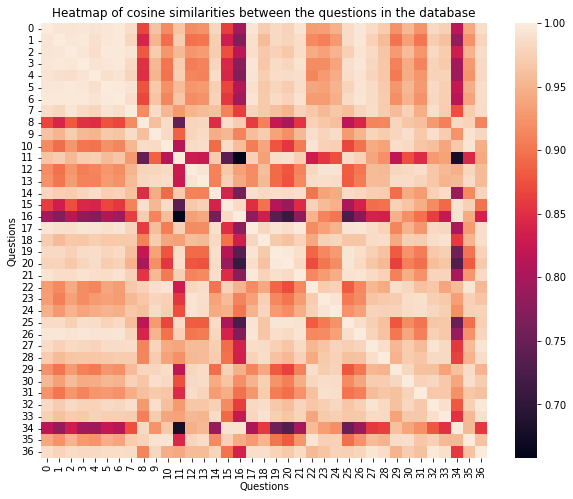

In [ ]:
plt.subplots(figsize=(10,8))
sns.heatmap(cosine_similarity(model(tokens)[1].numpy(),model(tokens)[1].numpy()))
plt.title('Heatmap of cosine similarities between the questions in the database')
plt.xlabel('Questions')
plt.ylabel('Questions');

### Examples

In [ ]:
def get_answer(question, model=model, encoded_questions=encoded_questions):
  
    token = tokenizer.encode_plus(
        question, 
        max_length = 512, # max length of the text that can go to BERT (<=512)
        padding='max_length',
        return_tensors="tf"
    )
    encoding = model(token)[1].numpy()
    similarity = cosine_similarity(encoding, encoded_questions, dense_output=True)
    idx = np.argsort(similarity)[0][::-1][0:5]
    [print('Similarity: ', similarity[0][i], '|| Q: ', 
           dog_emma.iloc[i].question, '|| A: ', 
           dog_emma.iloc[i].answer) for i in idx]

In [ ]:
question = 'How often should I walk my Labrador?'
get_answer(question)

Similarity:  1.0 || Q:  How often should I walk my Labrador? || A:  Full of energy, Labradors need over two hours of exercise per day to keep them physically and mentally fit.
Similarity:  0.9891799 || Q:  Are boy or girl labs better? || A:  Males may be more attentive than females. Males can be more protective of their things than females, although it is lessened with neutering. Males are more affectionate and more exuberant throughout their lifetime than females. Although both Lab boys and girls love food, males tend to be more food-motivated.
Similarity:  0.98684025 || Q:  Does a Labrador retriever mix shed? || A:  This mix breed dog can weigh 35 to 80 pounds and doesn't need much grooming to stay clean. However, you can expect year-round shedding and heavier sheds seasonally.
Similarity:  0.98594177 || Q:  What is a lab hound mix called? || A:  The Bassador is a mixed breed dog–a cross between the Basset Hound and the Labrador Retriever dog breeds. Loyal, sometimes stubborn, and al

In [ ]:
question = 'How often should my lab go out for a walk?'
get_answer(question)

Similarity:  0.99525225 || Q:  How often should I walk my Labrador? || A:  Full of energy, Labradors need over two hours of exercise per day to keep them physically and mentally fit.
Similarity:  0.992421 || Q:  Are boy or girl labs better? || A:  Males may be more attentive than females. Males can be more protective of their things than females, although it is lessened with neutering. Males are more affectionate and more exuberant throughout their lifetime than females. Although both Lab boys and girls love food, males tend to be more food-motivated.
Similarity:  0.98719096 || Q:  What is a lab hound mix called? || A:  The Bassador is a mixed breed dog–a cross between the Basset Hound and the Labrador Retriever dog breeds. Loyal, sometimes stubborn, and always sniffing around, these pups inherited some of the best traits from both of their parents.
Similarity:  0.98513293 || Q:  Does a Labrador retriever mix shed? || A:  This mix breed dog can weigh 35 to 80 pounds and doesn't need mu

In [ ]:
question = 'Are labradors violent?'
get_answer(question)


Similarity:  0.9968158 || Q:  What problems do Labradors have? || A:  The Labrador breed has a lifespan of 10 to 12 years. Some of the general health conditions that afflict Labradors are patellar luxation, canine hip dysplasia (CHD), and osteochondritis dissecans (OCD), which is canine elbow and shoulder dysplasia.
Similarity:  0.99472547 || Q:  What is Emma's color? || A:  Emma's color is Blond /None
Similarity:  0.994594 || Q:  What is her name? || A:  Her name is Emma
Similarity:  0.99427354 || Q:  Why you should not get a Labrador? || A:  The health issues, so many health issues Cuteness is in their genes and so are many other disorders. Labs are very prone to genetic problems such as hip dysplasia, osteochondritis dissecans (OCD), heart problems, and many more. Not only is this painful for the dog, but it is also painful for the owner.
Similarity:  0.99418604 || Q:  Will labs attack intruders? || A:  A Labrador may react then aggressively to an intruder either because some protec

### BERT Question-Answering Model

In [ ]:
# Load fine-tuned BERT large
model = TFBertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

All model checkpoint layers were used when initializing TFBertForQuestionAnswering.

All the layers of TFBertForQuestionAnswering were initialized from the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


In [ ]:
dogs_persona = pd.DataFrame(columns=['AnimalInternal-ID', 'persona1', 'persona2'])
dogs_persona['AnimalInternal-ID'] = dogs['AnimalInternal-ID']

personality = [
 ['Her name is {}'.format(name),
  '{} is a {}'.format(name, a_type),
  '{} is {}'.format(name, a_sex),
  '{}\'s weight is {}'.format(name, weight),
  '{}\'s date of birth is {}'.format(name, dob),
  '{}\'s breed is {}'.format(name, breed),
  '{}\'s color is {}'.format(name, color),
  '{} is {} years old'.format(name, int(age))
  ]

  if a_sex=='Female'

  else

  ['His name is {}'.format(name),
  '{} is a {}'.format(name, a_type),
  '{} is {}'.format(name, a_sex),
  '{}\'s weight is {}'.format(name, weight),
  '{}\'s date of birth is {}'.format(name, dob),
  '{}\'s breed is {}'.format(name, breed),
  '{}\'s color is {}'.format(name, color),
  '{} is {} years old'.format(name, int(age))
  ]

  for name, a_type, a_sex, weight, dob, breed, color, age in 
      zip(dogs.AnimalName, 
          dogs.AnimalType, 
          dogs.AnimalSex, 
          dogs.AnimalCurrentWeightPounds,
          dogs.AnimalDOB,
          dogs.AnimalBreed,
          dogs.AnimalColor,
          dogs.Age)
]

dogs_persona['persona1'] = personality
dogs_website_memos['AnimalInternal-ID'] = dogs_website_memos['AnimalInternal-ID'].astype('int')
#display(dogs_website_memos.groupby('AnimalInternal-ID').count().hist())
dogs_persona = dogs_persona.merge(dogs_website_memos.groupby('AnimalInternal-ID').first(),
                                  how='left', 
                                  on='AnimalInternal-ID')

no_memo = ~dogs_persona.MemoText.isna()
dogs_persona.loc[no_memo, 'persona2'] = dogs_persona.MemoText[no_memo].apply(lambda x: re.split('(?<=[.!?]) +',x))
dogs_persona = dogs_persona.drop(columns='MemoText').dropna()

In [ ]:
dogs_persona.head()

,AnimalInternal-ID,persona1,persona2
0,1444011,"[Her name is Emma, Emma is a Dog, Emma is Fema...",[Emma is a blonde princess who definitely like...
7,1444414,"[His name is Zydeco, Zydeco is a Dog, Zydeco i...","[Zydeco is an athletic, energetic, fun-loving ..."
11,1445198,"[Her name is Meadow, Meadow is a Dog, Meadow i...",[Meadow is a super sweet young dog who loves t...
12,1445280,"[Her name is Kit Kat, Kit Kat is a Dog, Kit Ka...",[If Kit Kat's shiny red coat and perfectly man...
14,1445310,"[Her name is Frida, Frida is a Dog, Frida is F...",[If you are looking for a sweet girl who wants...


In [ ]:
display(dogs_persona.persona1[7])
display(dogs_persona.persona2[7])

['His name is Zydeco',
 'Zydeco is a Dog',
 'Zydeco is Male',
 "Zydeco's weight is 51.0",
 "Zydeco's date of birth is 20150630",
 "Zydeco's breed is Mixed Breed (Large)",
 "Zydeco's color is Brown/White",
 'Zydeco is 6 years old']

['Zydeco is an athletic, energetic, fun-loving pal who would make the perfect jogging buddy!',
 'This smart, eager-to-please guy does very well on walks and runs and is incredibly alert to his surroundings.',
 "If he had his way, he'd catch every bird and squirrel he sees, and is thrilled to sniff around in the great outdoors!",
 "If you ask him if he wants to go for a run, he'll eagerly answer yes with sweet affectionate kisses!Zydeco  adores his people, and is very affectionate with his friends at the shelter.",
 "It's a very rewarding feeling to win his love!",
 'He really is the epitome of the ultimate loyal best friend.',
 "Zydeco also enjoys learning new things and is in APA!'s Total Obedience Program.",
 "The Total Obedience Program (TOP) is modeled after the AKC's Canine Good Citizen (CGC) test.",
 'As a TOP dog, Zydeco has a personalized training plan and works with a volunteer trainer several times a week to help him learn the skills to become the best dog he can be!',
 'Zyde

In [ ]:
emma_string = '. '.join(dogs_persona.persona1[0]) + '. ' + '. '.join(dogs_persona.persona2[0])

print(wrapper.fill(emma_string))

Her name is Emma. Emma is a Dog. Emma is Female. Emma's weight is 53.3. Emma's
date of birth is 20150306. Emma's breed is Retriever, Yellow Labrador /Mix.
Emma's color is Blond /None. Emma is 6 years old. Emma is a blonde princess who
definitely likes the finer things in life - like kisses and hugs from her
humans.. She is so happy to be alive and even happier when her hair can be
flying out a car window!This very affectionate, funny girl, now in foster care,
always wants to start her day by getting those hugs and kisses from her person..
And then she's ready for a day of playing with her brother and her foster dog
buddy and playing fetch and tug-o-war.When playtime is done, Emma is also ready
for her schooling.. This spontaneous girl is a fast learner who already answers
to the Come, Stop, No commands and is working on Sit, Stay and Place.. She's
crate trained, house trained and is always happy to match her person's activity
level - up for a morning jog, then hanging out on the couch.

In [ ]:
def answer_question(question, answer_text, return_scores=False):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    If return_scores is True, returns:
    tokens: tokens from BERT tokenizer,
    start_scores: Logits for each token for `start` classification
    end_scores: Logits for each token for `end` classification
    
    Code adapted from:
    https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT/
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)

    # Report how long the input sequence is.
    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example question through the model.
    model_result = model(tf.convert_to_tensor([input_ids]), # The tokens representing our input text.
                        token_type_ids=tf.convert_to_tensor([segment_ids])) # The segment IDs to differentiate question from answer_text
    start_scores, end_scores = model_result[0][0], model_result[1][0]

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = tf.argmax(start_scores)
    answer_end = tf.argmax(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]

    print('Answer: "' + answer + '"')

    if return_scores:
        return tokens, start_scores.numpy(), end_scores.numpy()

### Examples

In [ ]:
question = "What's the dogs name?"

answer_question(question, emma_string)

Query has 340 tokens.

Answer: "emma"


### Look at the probabilities of the start and end tokens

In [ ]:
question = "What's Emma's breed?"
tokens, start_scores, end_scores = answer_question(question, emma_string, return_scores=True)

Query has 341 tokens.

Answer: "retriever , yellow labrador / mix"


In [ ]:
question = "What's Emma's date of birth?"

answer_question(question, emma_string)

Query has 343 tokens.

Answer: "20150306"


In [ ]:
question = "How old is Emma?"

answer_question(question, emma_string)

Query has 338 tokens.

Answer: "6 years old"


Query has 341 tokens.

Answer: "retriever , yellow labrador / mix"


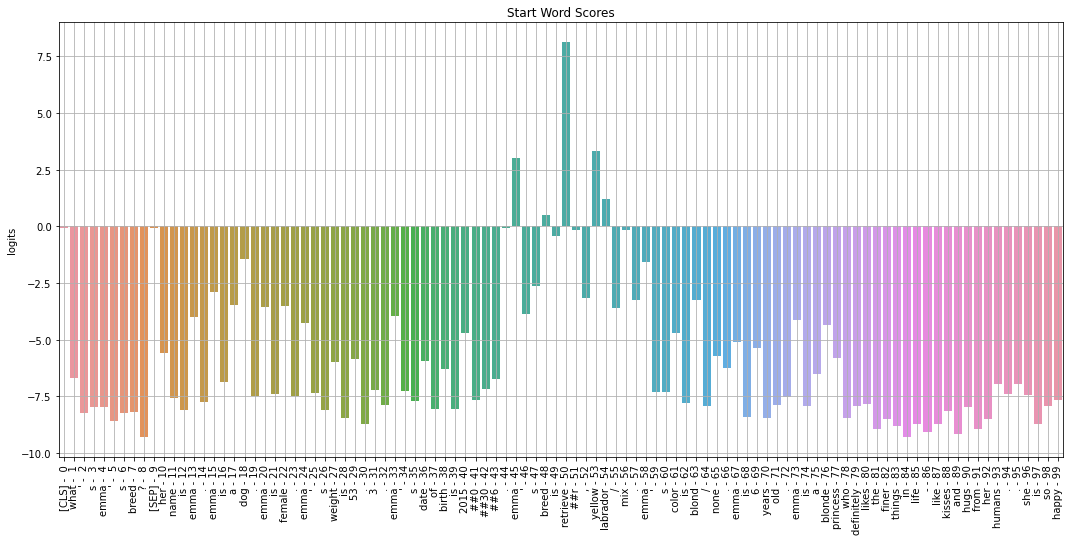

In [ ]:
question = "What's Emma's breed?"
tokens, start_scores, end_scores = answer_question(question, emma_string, return_scores=True)

token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))

# Turn on the vertical grid to help align words to scores.
plt.subplots(figsize=(18,8))

ax = sns.barplot(x=token_labels[0:100], y=start_scores[0:100], ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

ax.grid(True)

plt.title('Start Word Scores')
plt.ylabel('logits')

plt.savefig("./figure3_i")
#plt.show()

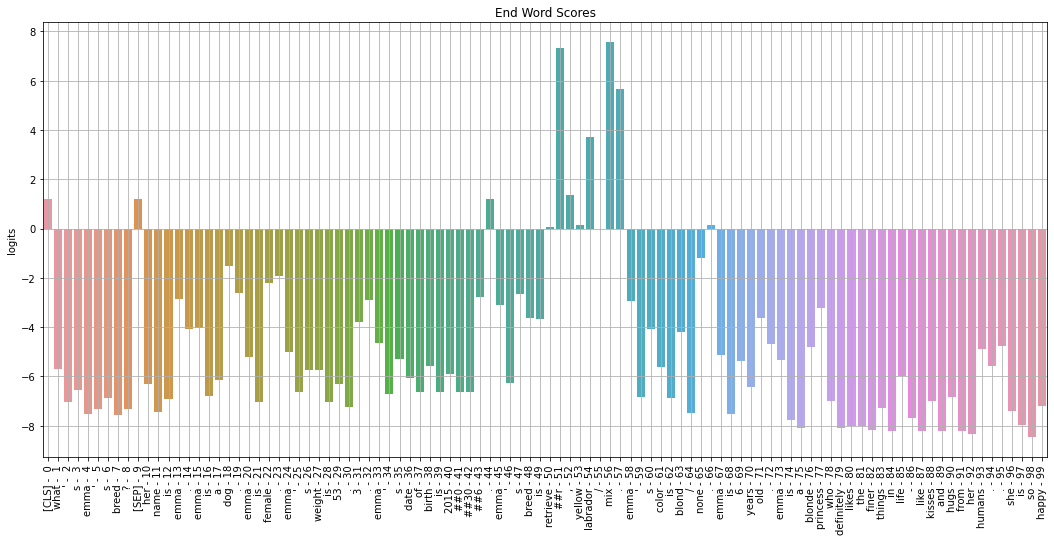

In [ ]:
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))

# Turn on the vertical grid to help align words to scores.
plt.subplots(figsize=(18,8))

ax = sns.barplot(x=token_labels[0:100], y=end_scores[0:100], ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

ax.grid(True)

plt.title('End Word Scores')
plt.ylabel('logits')
plt.savefig("./figure3_ii")
#plt.show()